# analiza oparta o łączenie OTP z gtfsami po krzyżu - OTP na bazie GTFSa z plikami rt-GTFS i vice versa

In [355]:
# niezbędne importy i wczytanie danych
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import xyzservices.providers as xyz
import pyproj


df = pd.read_csv('./otpdata/itineraries.csv', sep = ';')
df['legs'] = df['legs'].apply(ast.literal_eval)
df['route_coordinates'] = df['route_coordinates'].apply(ast.literal_eval)
rt_df = pd.read_csv('./otpdata/rt_itineraries.csv', sep = ';')
rt_df['legs'] = rt_df['legs'].apply(ast.literal_eval)
rt_df['route_coordinates'] = rt_df['route_coordinates'].apply(ast.literal_eval)
df = df[df['transfers'] > 0]
rt_df = rt_df[rt_df['transfers'] > 0] 

In [356]:
mapping = {
    'francuska': 'ul. francuska',
    'palac_krolewski_stare_miasto': 'Pałac Królewski - Stare Miasto',
    'mordor': 'Galeria Mokotów',
    'pkin': 'PKiN',
    'sokowirówka_wilanów': 'Świątynia Opatrzności - Wilanów',
    'muzeum_kopernika': 'Muzeum Kopernika',
    'powazki': 'cmentarz Powązki',
    'stadion_narodowy': 'Stadion Narodowy',
    'lotnisko': 'Lotnisko Chopina',
    'muzeum_wilanow' : 'Muzeum Wilanów',
    'muzeum_powstania' : 'Muzeum Powstania Warszawskiego',
    'wyscigi_konne_sluzew' : 'Tor Wyścigów Konnych - Służew',
    'promenada' : 'Promenada'
}

df['location_from_name'] = df['location_from_name'].replace(mapping)
df['location_to_name'] = df['location_to_name'].replace(mapping)
rt_df['location_from_name'] = rt_df['location_from_name'].replace(mapping)
rt_df['location_to_name'] = rt_df['location_to_name'].replace(mapping)

In [357]:
def decode(point_str):
    coord_chunks = [[]]
    
    for char in point_str:
        value = ord(char) - 63
        split_after = not (value & 0x20)
        value &= 0x1F
        coord_chunks[-1].append(value)
        
        if split_after:
            coord_chunks.append([])
    
    coord_chunks.pop()

    coords = []

    for coord_chunk in coord_chunks:
        coord = 0

        for i, value in enumerate(coord_chunk):
            coord |= value << (i * 5)

        if coord & 0x1:
            coord = ~coord
        coord >>= 1
        coord /= 100000.0

        coords.append(coord)

    points = []
    prev_x, prev_y = 0, 0

    for i in range(0, len(coords) - 1, 2):
        if coords[i] == 0 and coords[i + 1] == 0:
            continue

        prev_x += coords[i + 1]
        prev_y += coords[i]
        points.append([round(prev_x, 6), round(prev_y, 6)])

    return points

In [358]:
def normalize_and_append(row):
    normalized_data = pd.json_normalize(row['legs'])

    normalized_data['legStartTime'] = pd.to_datetime(normalized_data['startTime'] + normalized_data['agencyTimeZoneOffset'], unit='ms')
    normalized_data['legEndTime'] = pd.to_datetime(normalized_data['endTime'] + normalized_data['agencyTimeZoneOffset'], unit='ms')
    
    # Extract date and time components
    normalized_data['leg_nr'] = list(range(normalized_data.shape[0]))

    # Set the types of normalized_data columns to match the types of row columns
    for col in row.index:
        if col != 'legs':
            normalized_data[col] = [row[col]] * normalized_data.shape[0]
            if type(row[col]) is not list:
                normalized_data[col] = normalized_data[col].astype(type(row[col]))

    return normalized_data

In [359]:
df_legs = pd.DataFrame()
for num, row in df.iterrows():
    legs = normalize_and_append(row)
    
    df_legs = pd.concat([df_legs, legs])

rt_df_legs = pd.DataFrame()
for num, row in rt_df.iterrows():
    legs = normalize_and_append(row)
    
    rt_df_legs = pd.concat([rt_df_legs, legs])

In [360]:
# utilizing TimeZoneOffset
df_legs['to.arrival'] = np.int64(df_legs['to.arrival'])//10**6 + df_legs['agencyTimeZoneOffset']
df_legs['to.departure'] = np.int64(df_legs['to.departure'])//10**6 + df_legs['agencyTimeZoneOffset']
df_legs['from.arrival'] = np.int64(df_legs['from.arrival'])//10**6 + df_legs['agencyTimeZoneOffset']
df_legs['from.departure'] = np.int64(df_legs['from.departure'])//10**6 + df_legs['agencyTimeZoneOffset']

# Optimizing slicing
columns_to_slice = ['tripId', 'to.stopId', 'from.stopId']
df_legs[columns_to_slice] = df_legs[columns_to_slice].apply(lambda x: x.str.slice(2) if x.dtype == 'O' else x)

# Optimizing datetime conversion
datetime_columns = ['to.arrival', 'to.departure', 'from.arrival', 'from.departure']
df_legs[datetime_columns] = df_legs[datetime_columns].apply(pd.to_datetime, unit='ms')

# Extracting date and time
df_legs['to.arrivalDate'] = df_legs['to.arrival'].dt.strftime('%Y-%m-%d')
df_legs['to.arrivalTime'] = df_legs['to.arrival'].dt.strftime('%H:%M:%S')

df_legs['from.arrivalDate'] = df_legs['from.arrival'].dt.strftime('%Y-%m-%d')
df_legs['from.arrivalTime'] = df_legs['from.arrival'].dt.strftime('%H:%M:%S')

# Dropping unnecessary columns
columns_to_drop = ['departureDelay', 'arrivalDelay', 'realTime', 'alerts', 'agencyTimeZoneOffset', 'interlineWithPreviousLeg',
                    'steps', 'rentedBike', 'walkingBike', 'legGeometry.points', 'legGeometry.length', 'agencyName', 'agencyUrl', 'serviceDate']
df_legs.drop(columns=columns_to_drop, inplace=True)

print(df_legs.shape)

C:\Users\mipec\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\series.py:953: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)
C:\Users\mipec\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\series.py:953: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


(45191, 59)


In [361]:
# utilizing TimeZoneOffset
rt_df_legs['to.arrival'] = np.int64(rt_df_legs['to.arrival'])//10**6 + rt_df_legs['agencyTimeZoneOffset']
rt_df_legs['to.departure'] = np.int64(rt_df_legs['to.departure'])//10**6 + rt_df_legs['agencyTimeZoneOffset']
rt_df_legs['from.arrival'] = np.int64(rt_df_legs['from.arrival'])//10**6 + rt_df_legs['agencyTimeZoneOffset']
rt_df_legs['from.departure'] = np.int64(rt_df_legs['from.departure'])//10**6 + rt_df_legs['agencyTimeZoneOffset']

# Optimizing slicing
columns_to_slice = ['tripId', 'to.stopId', 'from.stopId']
rt_df_legs[columns_to_slice] = rt_df_legs[columns_to_slice].apply(lambda x: x.str.slice(2) if x.dtype == 'O' else x)

# Optimizing datetime conversion
datetime_columns = ['to.arrival', 'to.departure', 'from.arrival', 'from.departure']
rt_df_legs[datetime_columns] = rt_df_legs[datetime_columns].apply(pd.to_datetime, unit='ms')

# Extracting date and time
rt_df_legs['to.arrivalDate'] = rt_df_legs['to.arrival'].dt.strftime('%Y-%m-%d')
rt_df_legs['to.arrivalTime'] = rt_df_legs['to.arrival'].dt.strftime('%H:%M:%S')

rt_df_legs['from.arrivalDate'] = rt_df_legs['from.arrival'].dt.strftime('%Y-%m-%d')
rt_df_legs['from.arrivalTime'] = rt_df_legs['from.arrival'].dt.strftime('%H:%M:%S')

# Dropping unnecessary columns
columns_to_drop = ['departureDelay', 'arrivalDelay', 'realTime', 'alerts', 'agencyTimeZoneOffset', 'interlineWithPreviousLeg',
                    'steps', 'rentedBike', 'walkingBike', 'legGeometry.points', 'legGeometry.length', 'agencyName', 'agencyUrl', 'serviceDate']
rt_df_legs.drop(columns=columns_to_drop, inplace=True)

print(rt_df_legs.shape)

C:\Users\mipec\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\series.py:953: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)
C:\Users\mipec\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\series.py:953: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


(46143, 62)


In [362]:
import copy

directory = "../dane/gtfs-drive/"
df_legs_merged = pd.DataFrame()

for date in df_legs[df_legs['mode'] != 'WALK']['requestParameters.date'].unique():
    print(date)
    
    # Real-time data
    filepath_rt = directory + date + '-rt.gtfs'
    rt_df_stoptimes = pd.read_csv(filepath_rt + "/stop_times.txt")
    rt_df_stoptimes['stop_id'] = rt_df_stoptimes['stop_id'].str.strip()

    rt_from = copy.deepcopy(rt_df_stoptimes)
    rt_to = copy.deepcopy(rt_df_stoptimes)
    rt_from.columns = rt_from.columns.map(lambda x: "df_from_"+str(x))
    rt_to.columns = rt_to.columns.map(lambda x: "df_to_"+str(x))

    tmp = df_legs[df_legs['requestParameters.date'] == date].merge(rt_from, how='left', left_on=['tripId', 'from.stopId'], right_on=['df_from_trip_id', 'df_from_stop_id'])
    tmp = tmp.merge(rt_to, how='left', left_on=['tripId', 'to.stopId'], right_on=['df_to_trip_id', 'df_to_stop_id'])

    # Scheduled data
    # filepath_scheduled = directory + date + '.gtfs'
    # df_stoptimes = pd.read_csv(filepath_scheduled + "/stop_times.txt")
    # df_stoptimes['stop_id'] = df_stoptimes['stop_id'].str.strip()

    # df_from = copy.deepcopy(df_stoptimes)
    # df_to = copy.deepcopy(df_stoptimes)
    # df_from.columns = df_from.columns.map(lambda x: "legFrom_"+str(x))
    # df_to.columns = df_to.columns.map(lambda x: "legTo_"+str(x))

    # tmp2 = tmp.merge(df_from, how='left', left_on=['tripId', 'from.stopId'], right_on=['legFrom_trip_id', 'legFrom_stop_id'])
    # tmp2 = tmp2.merge(df_to, how='left', left_on=['tripId', 'to.stopId'], right_on=['legTo_trip_id', 'legTo_stop_id'])
    
    df_legs_merged = pd.concat([df_legs_merged, tmp])
df_legs_merged.head()

2022-03-30
2022-03-31
2022-04-13
2022-04-14
2022-04-19
2022-04-20
2022-04-21
2022-04-26
2022-04-27
2022-04-28
2022-05-10
2022-05-11
2022-05-12
2022-05-17
2022-05-19
2022-05-24
2022-05-25
2022-05-28
2022-05-31
2022-06-01
2022-06-02
2022-06-07
2022-06-08
2022-06-09
2022-06-14
2022-06-15
2022-06-16
2022-06-21
2022-06-22
2022-06-23
2022-11-22
2022-11-23
2022-11-24
2022-11-29
2022-11-30
2022-12-01
2022-12-06
2022-12-07
2022-12-08
2022-12-13
2022-12-14
2022-12-15
2023-04-25
2023-04-26
2023-04-27
2023-05-02
2023-05-25
2023-05-30
2023-05-31
2023-06-01
2023-06-06
2023-06-07
2023-06-13
2023-06-14
2023-06-15


,startTime,endTime,distance,generalizedCost,pathway,mode,transitLeg,route,duration,from.name,...,df_from_trip_id,df_from_arrival_time,df_from_departure_time,df_from_stop_id,df_from_stop_sequence,df_to_trip_id,df_to_arrival_time,df_to_departure_time,df_to_stop_id,df_to_stop_sequence
0,2022-03-30 04:35:52,2022-03-30 05:23:53,70.48,5414,False,WALK,False,,2881,Origin,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-03-30 04:35:52,2022-03-30 05:23:53,2739.75,5414,False,BUS,True,Utrata,2881,Francuska 01,...,138_6_39_0612,06:36:38,06:36:48,2153_01,23.0,138_6_39_0612,06:44:04,06:44:27,7037_06,26.0
2,2022-03-30 04:35:52,2022-03-30 05:23:53,159.15,5414,False,WALK,False,,2881,pl.Na Rozdrożu 06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-03-30 04:35:52,2022-03-30 05:23:53,5350.69,5414,False,BUS,True,Konwiktorska,2881,pl.Na Rozdrożu 01,...,503_5_181_0636,06:50:11,06:50:31,7037_01,12.0,503_5_181_0636,07:01:47,07:02:17,3039_01,17.0
4,2022-03-30 04:35:52,2022-03-30 05:23:53,210.14,5414,False,WALK,False,,2881,Dolina Służewiecka 01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [363]:
import copy

directory = "../dane/gtfs-drive/"
rt_df_legs_merged = pd.DataFrame()

for date in rt_df_legs[rt_df_legs['mode'] != 'WALK']['requestParameters.date'].unique():
    print(date)
    
    # Real-time data
    # filepath_rt = directory + date + '-rt.gtfs'
    # rt_df_stoptimes = pd.read_csv(filepath_rt + "/stop_times.txt")
    # rt_df_stoptimes['stop_id'] = rt_df_stoptimes['stop_id'].str.strip()

    # rt_from = copy.deepcopy(rt_df_stoptimes)
    # rt_to = copy.deepcopy(rt_df_stoptimes)
    # rt_from.columns = rt_from.columns.map(lambda x: "rtLegFrom_"+str(x))
    # rt_to.columns = rt_to.columns.map(lambda x: "rtLegTo_"+str(x))

    # tmp = df_legs[df_legs['requestParameters.date'] == date].merge(rt_from, how='left', left_on=['tripId', 'from.stopId'], right_on=['rtLegFrom_trip_id', 'rtLegFrom_stop_id'])
    # tmp = tmp.merge(rt_to, how='left', left_on=['tripId', 'to.stopId'], right_on=['rtLegTo_trip_id', 'rtLegTo_stop_id'])

    # Scheduled data
    filepath_scheduled = directory + date + '.gtfs'
    df_stoptimes = pd.read_csv(filepath_scheduled + "/stop_times.txt")
    df_stoptimes['stop_id'] = df_stoptimes['stop_id'].str.strip()

    df_from = copy.deepcopy(df_stoptimes)
    df_to = copy.deepcopy(df_stoptimes)
    df_from.columns = df_from.columns.map(lambda x: "df_from_"+str(x))
    df_to.columns = df_to.columns.map(lambda x: "df_to_"+str(x))

    tmp2 = rt_df_legs[rt_df_legs['requestParameters.date'] == date].merge(df_from, how='left', left_on=['tripId', 'from.stopId'], right_on=['df_from_trip_id', 'df_from_stop_id'])
    tmp2 = tmp2.merge(df_to, how='left', left_on=['tripId', 'to.stopId'], right_on=['df_to_trip_id', 'df_to_stop_id'])
    
    rt_df_legs_merged = pd.concat([rt_df_legs_merged, tmp2])

rt_df_legs_merged = rt_df_legs_merged.drop(columns = ['error.id', 'error.message', 'error.msg'])
rt_df_legs_merged.head()

2022-03-30
2022-03-31
2022-04-13
2022-04-14
2022-04-19
2022-04-20
2022-04-21
2022-04-26
2022-04-27
2022-04-28
2022-05-10
2022-05-11
2022-05-12
2022-05-17
2022-05-19
2022-05-24
2022-05-25
2022-05-28
2022-05-31
2022-06-01
2022-06-02
2022-06-07
2022-06-08
2022-06-09
2022-06-14
2022-06-15
2022-06-16
2022-06-21
2022-06-22
2022-06-23
2022-11-22
2022-11-23
2022-11-24
2022-11-29
2022-11-30
2022-12-01
2022-12-06
2022-12-07
2022-12-08
2022-12-13
2022-12-14
2022-12-15
2023-04-25
2023-04-26
2023-04-27
2023-05-02
2023-05-25
2023-05-30
2023-05-31
2023-06-01
2023-06-06
2023-06-07
2023-06-13
2023-06-14
2023-06-15


,startTime,endTime,distance,generalizedCost,pathway,mode,transitLeg,route,duration,from.name,...,df_from_trip_id,df_from_arrival_time,df_from_departure_time,df_from_stop_id,df_from_stop_sequence,df_to_trip_id,df_to_arrival_time,df_to_departure_time,df_to_stop_id,df_to_stop_sequence
0,2022-03-30 04:30:03,2022-03-30 05:33:21,468.01,6255,False,WALK,False,,3798,Origin,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-03-30 04:30:03,2022-03-30 05:33:21,2714.58,6255,False,TRAM,True,Żerań Wschodni,3798,Stare Miasto 02,...,4_8_171_0614,06:37:00,06:37:00,7047_02,18.0,4_8_171_0614,06:47:00,06:47:00,7013_07,23.0
2,2022-03-30 04:30:03,2022-03-30 05:33:21,90.87,6255,False,WALK,False,,3798,Centrum 07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-03-30 04:30:03,2022-03-30 05:33:21,7647.81,6255,False,BUS,True,pl.Piłsudskiego,3798,Centrum 06,...,175_070_77_0639,06:50:00,06:50:00,7013_06,11.0,175_070_77_0639,07:14:00,07:14:00,4200_01,31.0
4,2022-03-30 04:30:03,2022-03-30 05:33:21,1109.15,6255,False,WALK,False,,3798,Lotnisko Chopina-Odloty 01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [364]:
for iter_df in [df_legs_merged, rt_df_legs_merged]:
    for col in iter_df.columns:
        if iter_df[col].dtype != list:
            if iter_df[col].nunique() <= 1:
                try:
                    iter_df.drop(inplace = True, columns = [col])
                except:
                    print(col)

    cols = [
            'df_from_trip_id',
            'df_to_trip_id',
            'df_from_stop_sequence',
            'df_to_stop_sequence',
            'df_from_stop_id',
            'df_to_stop_id',
            'plan.from.lon',
            'plan.from.lat', 
            'plan.to.lon', 
            'plan.to.lat',
            
            
    ]
    iter_df.drop(inplace=True, columns = cols)
    iter_df = iter_df.reset_index(drop=True)
    iter_df.head()

In [365]:
rt_df_legs_merged.reset_index(drop=True, inplace = True)
df_legs_merged.reset_index(drop=True, inplace = True)

In [366]:
d = {x:int(x.split(':')[1])+1 for i, x in enumerate(list(set([x for i, x in enumerate(rt_df_legs_merged['df_to_arrival_time']) if not isinstance(x, float) and int(x.split(':')[0]) >= 24])))}
rt_df_legs_merged['df_to_arrival_time_offset'] = rt_df_legs_merged['df_to_arrival_time'].apply(lambda x: d.get(x))
# d = {x:int(x.split(':')[1])+1 for i, x in enumerate(list(set([x for i, x in enumerate(rt_df_legs_merged['df_from_departure_time']) if not isinstance(x, float) and int(x.split(':')[0]) >= 24])))}
# rt_df_legs_merged['df_to_departure_time_offset'] = rt_df_legs_merged['df_to_departure_time'].apply(lambda x: d.get(x))
rt_df_legs_merged['df_to_arrival_time'] = np.where(rt_df_legs_merged['df_to_arrival_time_offset'].notna(), '23:59:00', rt_df_legs_merged['df_to_arrival_time'])

In [367]:
for iter_df in [df_legs_merged, rt_df_legs_merged]:
    ts = pd.to_datetime(iter_df['df_from_departure_time'].str.strip(), format = '%H:%M:%S') - pd.to_datetime(iter_df['legStartTime'].dt.strftime('%H:%M:%S'), format = '%H:%M:%S')
    ts = ts.dt.total_seconds()
    iter_df['departureDelay'] = ts

    ts = pd.to_datetime(iter_df['df_to_arrival_time'].str.strip(), format = '%H:%M:%S') - pd.to_datetime(iter_df['legEndTime'].dt.strftime('%H:%M:%S'), format = '%H:%M:%S')
    ts = ts.dt.total_seconds()
    iter_df['arrivalDelay'] = ts
rt_df_legs_merged['departureDelay'] = -1 * rt_df_legs_merged['departureDelay']
rt_df_legs_merged['arrivalDelay'] = -1 * rt_df_legs_merged['arrivalDelay']
rt_df_legs_merged['arrivalDelay'] = rt_df_legs_merged['arrivalDelay'] + 60 * np.where(rt_df_legs_merged['df_to_arrival_time_offset'].notna(), rt_df_legs_merged['df_to_arrival_time_offset'], 0)
rt_df_legs_merged.drop(index = [41639], columns=['df_to_arrival_time_offset'], inplace = True) # błędnie podaje, że pojazd przyjechał ponad 15 minut za wcześnie

In [368]:
df_legs_merged.rename(columns = {'routeShortName':'line'})

# create transfer_nr as a 
df_legs_merged['transfer_nr'] = df_legs_merged[df_legs_merged['transitLeg']].groupby(['response_nr', 'itinerary_nr']).cumcount().astype(int)
df_legs_merged['transfer_nr'] = df_legs_merged['transfer_nr'].apply(lambda x: x if not np.isnan(x) else -1)

rt_df_legs_merged['transfer_nr'] = rt_df_legs_merged[rt_df_legs_merged['transitLeg']].groupby(['response_nr', 'itinerary_nr']).cumcount().astype(int)
rt_df_legs_merged['transfer_nr'] = rt_df_legs_merged['transfer_nr'].apply(lambda x: x if not np.isnan(x) else -1)

Text(0.5, 0.01, 'dla czytelności wykresu usunięto skrajne 2.5% przypadków')

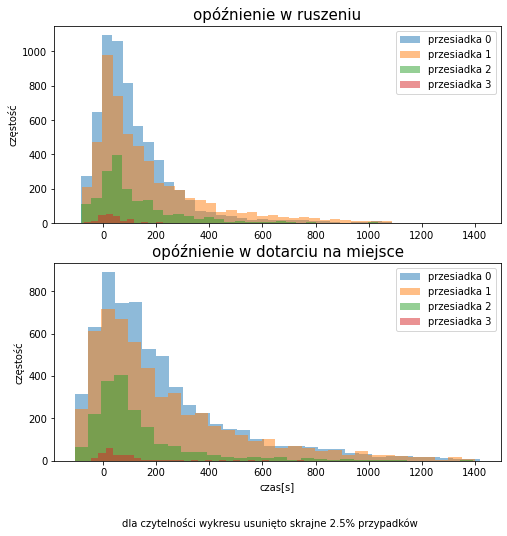

In [390]:
cmap_name = 'tab20'
cmap = plt.get_cmap(cmap_name)
cmap = cmap.colors
fig, axes = plt.subplots(2,1)
fig.set_size_inches(8,8)
import numpy as np

# Specify the desired quantiles
lower_quantile = 2.5
upper_quantile = 97.5

# Calculate the quantile values
lower_value = df_legs_merged['departureDelay'].quantile(lower_quantile / 100)
upper_value = df_legs_merged['departureDelay'].quantile(upper_quantile / 100)
filtered_df = df_legs_merged[df_legs_merged['departureDelay'].between(lower_value, upper_value)]

lower_value = df_legs_merged['arrivalDelay'].quantile(lower_quantile / 100)
upper_value = df_legs_merged['arrivalDelay'].quantile(upper_quantile / 100)
filtered_df = filtered_df[filtered_df['arrivalDelay'].between(lower_value, upper_value)]
for transfer_nr in filtered_df['transfer_nr'].drop_duplicates():
    data = filtered_df[filtered_df['transfer_nr'] == transfer_nr]
    axes[0].hist(data['departureDelay'], alpha = 0.5, color = cmap[2*int(transfer_nr)], bins = 30, label = f'przesiadka {int(transfer_nr)}')
    axes[1].hist(data['arrivalDelay'], alpha = 0.5, color = cmap[2*int(transfer_nr)], bins = 30, label = f'przesiadka {int(transfer_nr)}')
axes[0].legend()
axes[0].set_title('opóźnienie w ruszeniu', fontsize = 15)
axes[1].set_title('opóźnienie w dotarciu na miejsce', fontsize = 15)
axes[1].set_xlabel('czas[s]')
axes[0].set_ylabel('częstość')
axes[1].set_ylabel('częstość')
axes[0].set_xlim(axes[1].get_xlim())
axes[1].legend()
# plt.suptitle(, fontsize = 18)
plt.figtext(0.5, 0.01, 'dla czytelności wykresu usunięto skrajne 2.5% przypadków', wrap = True, ha = 'center', fontsize = 10)

departure, transfer 0 0.08157083717563124 2.9646921710512554e-20
departure, transfer 1 0.10364404911225246 3.5713783262559347e-31
departure, transfer 2 0.05711097722070341 5.91053536051198e-05
departure, transfer 3 0.2826678466946923 4.0835105090284837e-16
arrival, transfer 0 0.06480958834035182 6.078420356257833e-13
arrival, transfer 1 0.07317851918020239 9.51985995372181e-16
arrival, transfer 2 0.19625237376894022 3.368065750719665e-54
arrival, transfer 3 0.3562852062180921 1.30229932050678e-25


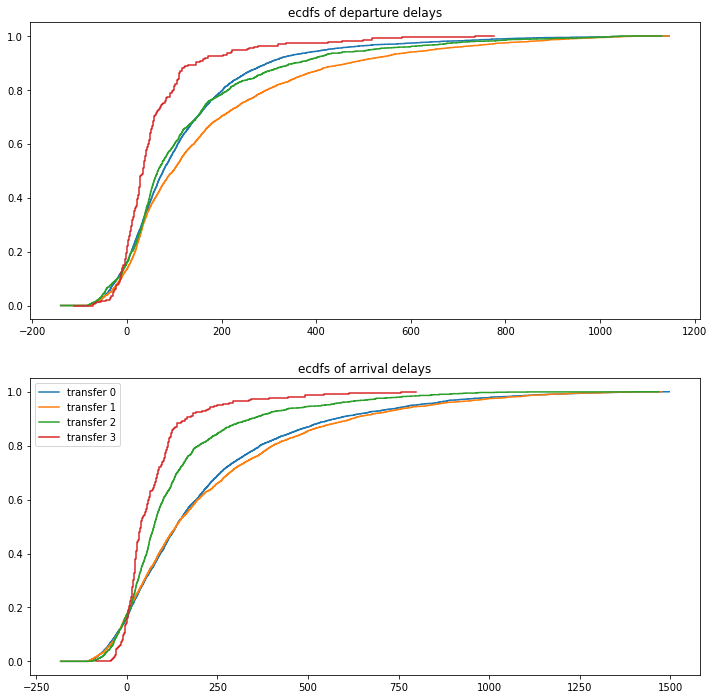

In [409]:
import itertools
from scipy import stats
cmap_name = 'tab20'
cmap = plt.get_cmap(cmap_name)
cmap = cmap.colors
samples_departure = []
samples_arrival = []

for transfer_nr in filtered_df['transfer_nr'].drop_duplicates():
    data = filtered_df[filtered_df['transfer_nr'] == transfer_nr]
    samples_departure.append(data['departureDelay'])
    samples_arrival.append(data['arrivalDelay'])

samples = samples_departure
p_val = []
ks_stat = []
for i in range(len(samples)):
    l1 = np.array(list(itertools.chain(*samples[0:i])) + list(itertools.chain(*samples[i+1::])))
    l2 = np.array(list(samples[i]))
    res = stats.kstest(rvs = l1, cdf = l2)
    p_val.append(res.pvalue)
    ks_stat.append(res.statistic)
    print(f'departure, transfer {i}',res.statistic, res.pvalue)

samples = samples_arrival
p_val = []
ks_stat = []

for i in range(len(samples)):
    l1 = np.array(list(itertools.chain(*samples[0:i])) + list(itertools.chain(*samples[i+1::])))
    l2 = np.array(list(samples[i]))
    res = stats.kstest(rvs = l1, cdf = l2)
    p_val.append(res.pvalue)
    ks_stat.append(res.statistic)
    print(f'arrival, transfer {i}', res.statistic, res.pvalue)

fig, ax = plt.subplots(2,1)
fig.set_size_inches(12,12)

ecdfs_departure = [stats.ecdf(sample) for sample in samples_departure]
ecdfs_arrival = [stats.ecdf(sample) for sample in samples_arrival]

for i, ecdf in enumerate(ecdfs_departure):
    ecdf.cdf.plot(ax=ax[0], label = f'transfer {i}', c = cmap[2*i])
ax[0].set_title('ecdfs of departure delays')
for i, ecdf in enumerate(ecdfs_arrival):
    ecdf.cdf.plot(ax=ax[1], label = f'transfer {i}', c = cmap[2*i])
ax[1].set_title('ecdfs of arrival delays')
plt.legend()

Text(0.5, 1.0, 'opóźnienia w ruszeniu i w dotarciu na miejsce poszczególnych przejazdów na trasie\ndla czytelności wykresu usunięto skrajne 2.5% przypadków')

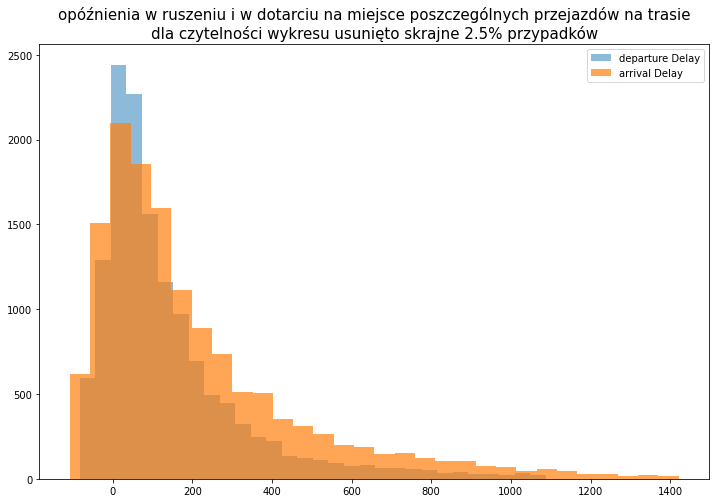

In [369]:
cmap_name = 'tab20'
cmap = plt.get_cmap(cmap_name)
cmap = cmap.colors
fig, ax = plt.subplots(1,1)
fig.set_size_inches(12,8)
import numpy as np

# Specify the desired quantiles
lower_quantile = 2.5
upper_quantile = 97.5

# Calculate the quantile values
lower_value = df_legs_merged['departureDelay'].quantile(lower_quantile / 100)
upper_value = df_legs_merged['departureDelay'].quantile(upper_quantile / 100)
filtered_df = df_legs_merged[df_legs_merged['departureDelay'].between(lower_value, upper_value)]

lower_value = df_legs_merged['arrivalDelay'].quantile(lower_quantile / 100)
upper_value = df_legs_merged['arrivalDelay'].quantile(upper_quantile / 100)
filtered_df = filtered_df[filtered_df['arrivalDelay'].between(lower_value, upper_value)]

ax.hist(filtered_df['departureDelay'], alpha = 0.5, color = cmap[0], bins = 30)
ax.hist(filtered_df['arrivalDelay'], alpha = 0.7, color = cmap[2], bins = 30)
plt.legend(['departure Delay', 'arrival Delay'])
plt.title('opóźnienia w ruszeniu i w dotarciu na miejsce poszczególnych przejazdów na trasie\ndla czytelności wykresu usunięto skrajne 2.5% przypadków', fontsize = 15)

In [400]:
np.mean(df_legs_merged['arrivalDelay'] < 0)

0.06348468755531952

In [396]:
df_legs_merged[(df_legs_merged['transfer_nr'] == 0) & df_legs_merged['departureDelay'] < 0]

,startTime,endTime,distance,generalizedCost,mode,transitLeg,route,duration,from.name,from.lon,...,to.arrivalTime,from.arrivalDate,from.arrivalTime,df_from_arrival_time,df_from_departure_time,df_to_arrival_time,df_to_departure_time,departureDelay,arrivalDelay,transfer_nr


### czy jeśli poprzednie przejazdy na trasie się powiodły, jaka jest szansa że następny się powiedzie

In [273]:
for i in range(4):
    condition = df_legs_merged[(df_legs_merged['transfer_nr'] == i) & (df_legs_merged['departureDelay'] < 0)][['response_nr', 'itinerary_nr']].drop_duplicates()

    # Merge with the main DataFrame on the specified columns
    df = pd.merge(df, condition, on=['response_nr', 'itinerary_nr'], how='left', indicator=True)

    # Create 'transfer0' column based on the merge indicator
    df[f'transfer{i}'] = df['_merge'] == 'both'

    # # Drop the indicator column if you don't need it
    df = df.drop('_merge', axis=1)

In [285]:
# Assuming 'transfer1' is a Series obtained from df.groupby(['response_nr', 'itinerary_nr'])['transfer_nr'].max()
tmp = df.groupby(['response_nr', 'itinerary_nr'])['transfer_nr'].max()

# Filter rows based on the maximum 'transfer_nr' being at least 1
transfer1 = df[df.apply(lambda row: row['transfer_nr'] == tmp.get((row['response_nr'], row['itinerary_nr']), 0), axis=1) & (tmp >= 1)]
transfer1

KeyError: 'Column not found: transfer_nr'

In [283]:
df['transfer0'].mean()

0.035077677841373674

In [278]:
df.groupby('transfer0')['transfer1'].mean()

transfer0
False    0.089387
True     0.120408
Name: transfer1, dtype: float64

In [279]:
df.groupby(['transfer0', 'transfer1'])['transfer2'].mean()

transfer0  transfer1
False      False        0.027802
           True         0.076253
True       False        0.042343
           True         0.110169
Name: transfer2, dtype: float64

In [280]:
df.groupby(['transfer0', 'transfer1', 'transfer2'])['transfer3'].mean()

transfer0  transfer1  transfer2
False      False      False        0.002530
                      True         0.019231
           True       False        0.005896
                      True         0.042857
True       False      False        0.003634
                      True         0.068493
           True       False        0.004762
                      True         0.038462
Name: transfer3, dtype: float64

### porównać czas spędzony w transporcie vs czas spaceru vs czas oczekiwania (oś x - duration, oś y - proporcja czasu spędzonego w dany sposób {czyli np waitTime/Duration})

In [298]:
df.drop(columns='transfers', inplace=True)
max_transfers = df_legs_merged.groupby(['response_nr', 'itinerary_nr'])['transfer_nr'].max().reset_index()

# Merge with the original DataFrame on 'response_nr' and 'itinerary_nr'
df = pd.merge(df, max_transfers, on=['response_nr', 'itinerary_nr'], how='left')

# Rename the new column to 'transfers'
df = df.rename(columns={'transfer_nr': 'transfers'})
df['transfers']

0        2.0
1        1.0
2        1.0
3        2.0
4        1.0
        ... 
12225    1.0
12226    0.0
12227    1.0
12228    1.0
12229    1.0
Name: transfers, Length: 12230, dtype: float64

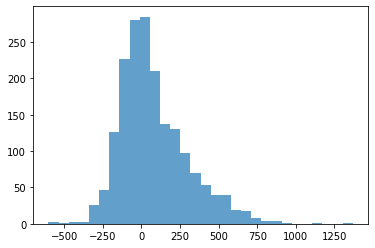

In [299]:
df_merged = df.merge(rt_df, on = ['requestParameters.date', 'requestParameters.time', 'route_coordinates_str'], how = 'inner', suffixes=['_expected', '_real'])
# print(f'proportion of advertised routes that are realisable {df_merged.shape[0]/df.shape[0]}')
df_merged['time_difference'] = df_merged[['duration_expected', 'duration_real']].apply(lambda x: x.duration_real - x.duration_expected, axis=1)
plt.hist(df_merged['time_difference'], color = cmap[0], alpha = 0.7, bins = 30)
plt.show()

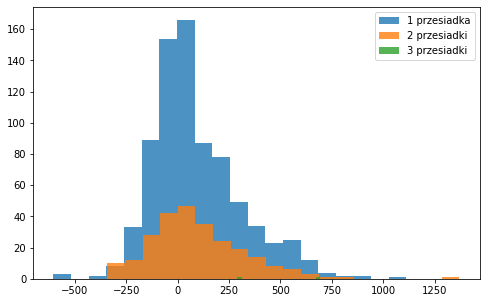

In [354]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,5)
for i, (group_name, data) in enumerate(df_merged[df_merged['transfers_expected'] > 0].groupby('transfers_expected')):
    data = data['time_difference']
    ax.hist(data, bins = 20, color = cmap[2*i], alpha = 0.8, label = f'{int(group_name)} {["przesiadki" if int(group_name) > 1 else "przesiadka"].pop()}', zorder = i)
plt.legend()

### a co gdybyśmy pojechali tymi trasami, które zostały zaproponowane?

In [401]:
df_legs_merged[df_legs_merged['transfer_nr'] == 0]

,startTime,endTime,distance,generalizedCost,mode,transitLeg,route,duration,from.name,from.lon,...,to.arrivalTime,from.arrivalDate,from.arrivalTime,df_from_arrival_time,df_from_departure_time,df_to_arrival_time,df_to_departure_time,departureDelay,arrivalDelay,transfer_nr
1,2022-03-30 04:35:52,2022-03-30 05:23:53,2739.75,5414,BUS,True,Utrata,2881,Francuska 01,21.054000,...,02:27:28,1970-01-01,02:27:28,06:36:38,06:36:48,06:44:04,06:44:27,-12.0,4.0,0.0
8,2022-03-30 04:35:52,2022-03-30 05:24:18,4394.32,4728,BUS,True,Utrata,2906,Francuska 01,21.054000,...,02:27:28,1970-01-01,02:27:28,06:36:38,06:36:48,06:49:14,06:49:38,-12.0,14.0,0.0
13,2022-03-30 04:35:52,2022-03-30 05:25:53,5734.50,4670,BUS,True,Utrata,3001,Francuska 01,21.054000,...,02:27:28,1970-01-01,02:27:28,06:36:38,06:36:48,06:54:16,06:54:38,-12.0,16.0,0.0
17,2022-03-30 04:38:52,2022-03-30 05:28:53,430.67,5454,BUS,True,Falenica,3001,Francuska 02,21.054000,...,02:27:28,1970-01-01,02:27:28,06:38:19,06:39:08,06:41:39,06:41:47,-52.0,-21.0,0.0
23,2022-03-30 04:42:37,2022-03-30 05:29:18,2210.74,4816,BUS,True,pl.Hallera,2801,rondo Waszyngtona 01,21.050000,...,02:27:28,1970-01-01,02:27:28,06:52:03,06:52:13,06:59:48,07:00:08,73.0,48.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45169,2023-06-15 21:44:07,2023-06-15 22:47:39,3404.70,6502,TRAM,True,Gocławek,3812,rondo Waszyngtona 05,21.050035,...,02:28:06,1970-01-01,02:28:06,NaN,NaN,NaN,NaN,NaN,NaN,0.0
45174,2023-06-15 21:56:07,2023-06-15 23:06:13,2378.05,7334,TRAM,True,Gocławek,4206,rondo Waszyngtona 05,21.050035,...,02:28:06,1970-01-01,02:28:06,NaN,NaN,NaN,NaN,NaN,NaN,0.0
45179,2023-06-15 21:51:28,2023-06-15 23:06:17,1015.69,7327,BUS,True,Falenica,4489,Wybrzeże Szczecińskie 02,21.041993,...,02:28:06,1970-01-01,02:28:06,23:56:48,23:57:43,NaN,NaN,86263.0,NaN,0.0
45183,2023-06-15 21:34:47,2023-06-15 22:23:28,6857.87,4982,BUS,True,pl.Piłsudskiego,2921,Terminal Autokarowy 02,20.975185,...,02:28:06,1970-01-01,02:28:06,23:43:41,23:43:53,NaN,NaN,53.0,NaN,0.0
